In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import pysm3
import pysm3.units as u
from fgbuster import get_instrument, get_sky, get_observation, get_noise_realization
from fgbuster.visualization import corner_norm
from fgbuster import (CMB, Dust, Synchrotron, basic_comp_sep, xForecast)
from original_tools import delta_r_estimator, Cl2Dl

In [2]:
NSIDE = 128
npix = hp.nside2npix(NSIDE)
instrument = get_instrument('IMo-v1.1')
sky_vary = get_sky(NSIDE, 'c1d1s1')

/home/cmb/yusuket/.conda/envs/hpenv/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/camb_lenspotentialCls.dat (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/cmb/yusuket/.conda/envs/hpenv/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/delens_ells.txt (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/cmb/yusuket/.conda/envs/hpenv/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/cmb/yusuket/.conda/envs/hpenv/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/cmb/yusuket/.conda/envs/hpen

In [3]:
NSIDE_PATCH = 8
for spectral_param in [sky_vary.components[1].mbb_index,
                       sky_vary.components[1].mbb_temperature,
                       sky_vary.components[2].pl_index]:
    spectral_param[:] = hp.ud_grade(hp.ud_grade(spectral_param.value, NSIDE_PATCH),NSIDE) * spectral_param.unit

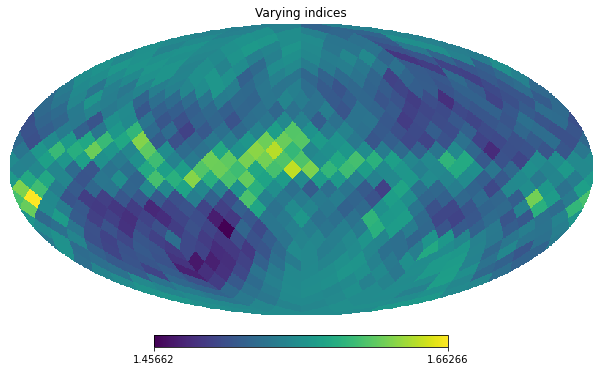

In [4]:
hp.mollview(sky_vary.components[1].mbb_index, title='Varying indices')

In [5]:
freq_maps_vary = get_observation(instrument, sky_vary)
freq_maps_vary = freq_maps_vary[:, 1:] # Select polarization

In [6]:
components = [CMB(), Dust(353.), Synchrotron(23.)]
# The starting point of the fit is the pysm default value, so let's shift it
components[1].defaults = [1.6, 22.]
components[2].defaults = [-2.7]

In [7]:
nside_fit = NSIDE_PATCH
result_vary = basic_comp_sep(components, instrument, freq_maps_vary, nside_fit)

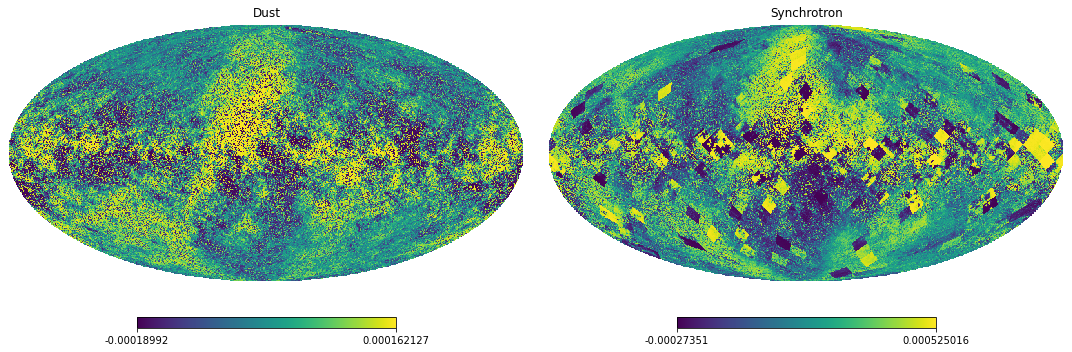

In [8]:
plt.figure(figsize=(15,10))
hp.mollview(result_vary.s[1,1]
            - sky_vary.components[1].U_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_vary.components[1].freq_ref_P)).value,
            title='Dust', norm='hist', sub=(1,2,1))
hp.mollview(result_vary.s[2,1]
            - sky_vary.components[2].U_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_vary.components[2].freq_ref_P)).value,
            title='Synchrotron', norm='hist', sub=(1,2,2))

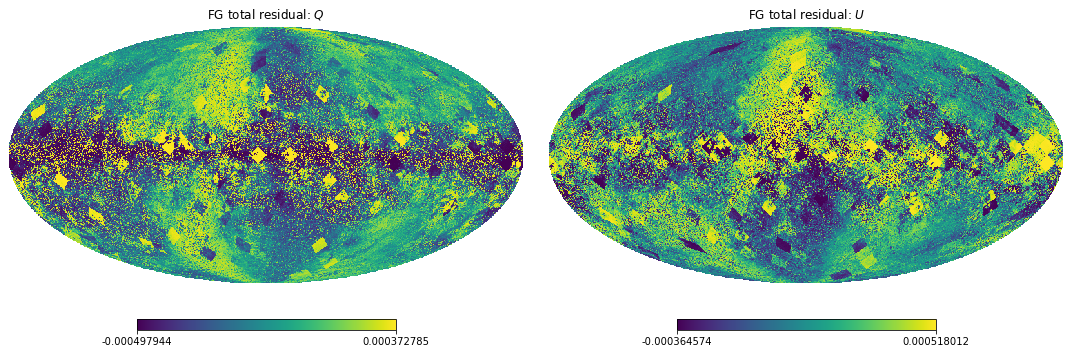

In [9]:
res_dust_Q = result_vary.s[1,0] - sky_vary.components[1].Q_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_vary.components[1].freq_ref_P)).value
res_dust_U = result_vary.s[1,1] - sky_vary.components[1].U_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_vary.components[1].freq_ref_P)).value

res_synch_Q = result_vary.s[2,0] - sky_vary.components[2].Q_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_vary.components[2].freq_ref_P)).value
res_synch_U = result_vary.s[2,1] - sky_vary.components[2].U_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky_vary.components[2].freq_ref_P)).value

res_FG = np.array([np.zeros(npix), res_dust_Q+res_synch_Q, res_dust_U+res_synch_U])

plt.figure(figsize=(15,10))
hp.mollview(res_FG[1], title="FG total residual: $Q$", sub=(1,2,1), norm="hist")
hp.mollview(res_FG[2], title="FG total residual: $U$", sub=(1,2,2), norm="hist")

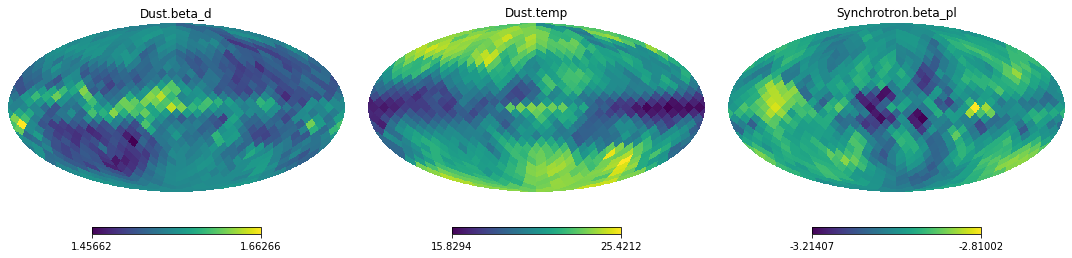

In [10]:
plt.figure(figsize=(15,10))
for i, par in enumerate(result_vary.params):
    hp.mollview(result_vary.x[i], title=par, sub=(1,3,i+1))

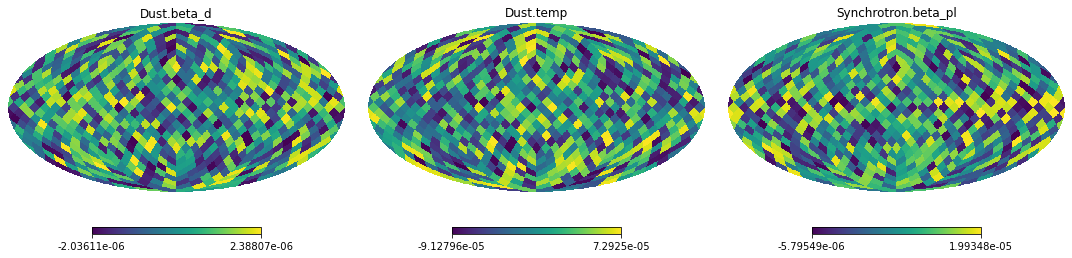

In [11]:
plt.figure(figsize=(15,10))
hp.mollview(hp.ud_grade(result_vary.x[0], NSIDE) -
            sky_vary.components[1].mbb_index,
            title=result_vary.params[0], norm='hist', sub=(1,3,1))
hp.mollview(hp.ud_grade(result_vary.x[1], NSIDE) -
            sky_vary.components[1].mbb_temperature.value,
            title=result_vary.params[1], norm='hist', sub=(1,3,2))
hp.mollview(hp.ud_grade(result_vary.x[2], NSIDE) -
            sky_vary.components[2].pl_index,
            title=result_vary.params[2], norm='hist', sub=(1,3,3))

In [12]:
input_cmb = sky_vary.components[0].map.value
result_cmb = np.array([np.zeros(npix), result_vary.s[0,0], result_vary.s[0,1]])

res_cmb = input_cmb - result_cmb                   

inputcl = hp.anafast(input_cmb)

rescl_cmb = hp.anafast(res_cmb)
rescl_FG = hp.anafast(res_FG)

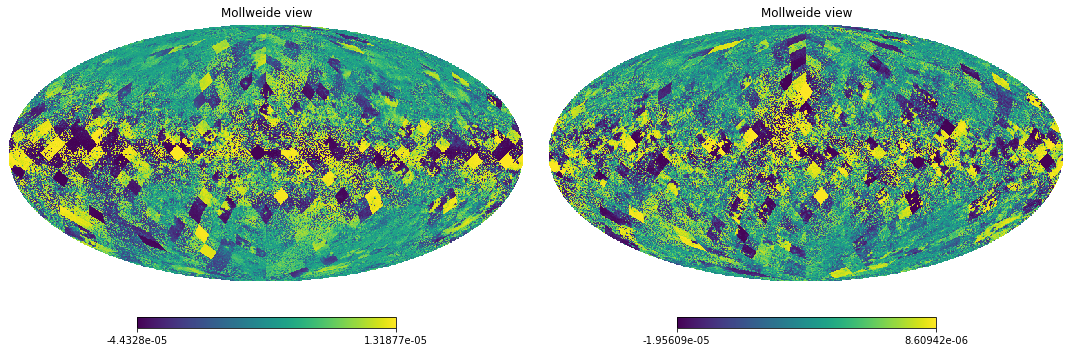

In [13]:
plt.figure(figsize=(15,10))
hp.mollview(res_cmb[1], sub=(1,2,1), norm="hist")
hp.mollview(res_cmb[2], sub=(1,2,2), norm="hist")

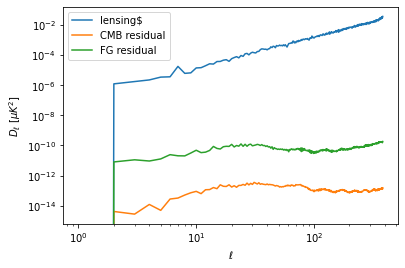

In [14]:
plt.loglog(Cl2Dl(inputcl[2,:]), label="lensing$")
plt.loglog(Cl2Dl(rescl_cmb[2,:]), label="CMB residual")
plt.loglog(Cl2Dl(rescl_FG[2,:]), label="FG residual")
plt.ylabel("$D_\ell ~ [\mu K^2]$")
plt.xlabel("$\ell$")
plt.legend()

delta_r:  1e-08


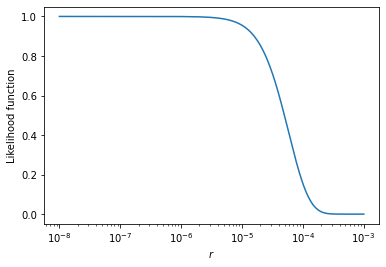

In [17]:
r = np.linspace(1e-8, 1e-3, 1000)
lmax = 3*NSIDE - 1
dr, L = delta_r_estimator(r, lmax, rescl_FG[2,:])
plt.plot(r, L)
plt.xscale("log")
plt.xlabel("$r$")
plt.ylabel("Likelihood function")
print("delta_r: ", dr)